In [1]:
%autosave 10

Autosaving every 10 seconds


# Phase 2 - Modeling

In [2]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from gurobipy import *
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
#from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\Ramy\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [46]:
default_seed = 2
output_file = "output_sample"

In [5]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [6]:
# Read the data and features from the pickle
data, discrete_features, continuous_features, ret_cols = pickle.load( open(r"C:\Users\Ramy\Desktop\Service\FinalSubmission\mypickle_notbalanced.pickle", "rb" ) )

In [7]:
data

,loan_number,amount_borrowed,borrower_rate,term,age_in_months,days_past_due,principal_balance,service_fees_paid,principal_paid,interest_paid,...,issue_d,last_pymnt_d,loan_length,loan_status,grade,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
1,79656,4000.0,0.1559,36.0,88,0,0.0,-51.84,4000.0,808.28,...,2013-01-02,2015-04-02,26,0.0,B,0.067357,0.093263,0.049251,0.063118,0.087959
2,79665,17500.0,0.2398,60.0,88,0,0.0,-66.89,17500.0,1604.20,...,2013-01-02,2015-04-02,26,0.0,C,0.018334,0.042309,0.026120,0.038315,0.060096
3,79659,15000.0,0.1564,60.0,88,0,0.0,-298.07,15000.0,4661.84,...,2013-01-02,2016-08-02,42,0.0,A,0.062158,0.088797,0.068232,0.077655,0.094240
4,79668,10000.0,0.2118,60.0,88,0,0.0,-235.48,10000.0,4987.94,...,2013-01-02,2016-08-02,42,0.0,C,0.099759,0.142513,0.107311,0.119069,0.139884
5,79662,9500.0,0.1939,36.0,88,0,0.0,-98.53,9500.0,1910.21,...,2013-01-02,2015-04-02,26,0.0,C,0.067025,0.092804,0.049043,0.062894,0.087708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198746,1167680,10500.0,0.1628,60.0,17,0,0.0,-42.70,10500.0,646.63,...,2018-12-31,2019-06-30,5,0.0,C,0.012317,0.147801,0.024341,0.043642,0.079493
198748,1171231,9500.0,0.1003,36.0,17,0,0.0,-76.21,9500.0,711.10,...,2018-12-31,2019-11-30,10,0.0,A,0.024951,0.089823,0.026058,0.043748,0.076294
198750,1167848,7000.0,0.0904,36.0,17,0,0.0,-69.31,7000.0,582.61,...,2018-12-31,2020-02-11,13,0.0,A,0.027743,0.076828,0.027171,0.043905,0.074520
198751,1180476,8500.0,0.2204,36.0,17,0,0.0,-42.17,8500.0,864.68,...,2018-12-31,2019-07-03,6,0.0,C,0.033909,0.203454,0.032619,0.052297,0.088786


In [8]:
# Create the outcome
data["outcome"] = data.loan_status

In [9]:
# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

In [10]:
# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

In [11]:
X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)

# category = pd.get_dummies(data["ListingCategory"])
# X_discrete = data.join(category, rsuffix="_category")
# X_discrete.drop("ListingCategory", axis=1, inplace=True)

# employment = pd.get_dummies(X_discrete["EmploymentStatus"])
# X_discrete = X_discrete.join(employment, rsuffix="_employmentstatus")
# X_discrete.drop("EmploymentStatus", axis=1, inplace=True)


# state = pd.get_dummies(X_discrete["BorrowerState"])
# X_discrete = X_discrete.join(state, rsuffix="_state")
# X_discrete.drop("BorrowerState", axis=1, inplace=True)


# X_discrete = X_discrete.join(category, rsuffix="_category")
# X_discrete.drop("ListingCategory", axis=1, inplace=True)
# X_discrete = X_discrete.join(employment, rsuffix="_employmentstatus")
# X_discrete.drop("EmploymentStatus", axis=1, inplace=True)
# X_discrete = X_discrete.join(state, rsuffix="_state")
# X_discrete.drop("BorrowerState", axis=1, inplace=True)

discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values
#pd.set_option("display.max_columns", len(X_discrete.columns))
#X_discrete.head()

In [12]:
X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

### Prepare Data

In [45]:
train

array([ True, False,  True, ..., False, False, False])

In [13]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

### Fit Classification

In [14]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

### Fit Regression

In [15]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### Test Investments

In [16]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - ranking: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - regression: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - two-stage: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['amount_borrowed',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.amount_borrowed)/np.sum(pf_test.amount_borrowed)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Regression':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['amount_borrowed',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.amount_borrowed)/np.sum(pf_test.amount_borrowed)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Ranking':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['amount_borrowed',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.amount_borrowed)/np.sum(pf_test.amount_borrowed)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Two-stage':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['amount_borrowed',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.amount_borrowed)/np.sum(pf_test.amount_borrowed)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Crystal-ball':

            # Sort the loans by realized return
            data_test = data_test.sort_values(by=ret_col, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['amount_borrowed',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.amount_borrowed)/np.sum(pf_test.amount_borrowed)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

## Baseline models
See how well we do using grade or interest rate only

### Grade

  Model: Grade only logistic l2
Fit time: 0.24 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.84895
              precision    recall  f1-score   support

  No default     0.8489    1.0000    0.9183     16979
     Default     0.0000    0.0000    0.0000      3021

    accuracy                         0.8489     20000
   macro avg     0.4245    0.5000    0.4592     20000
weighted avg     0.7207    0.8489    0.7796     20000



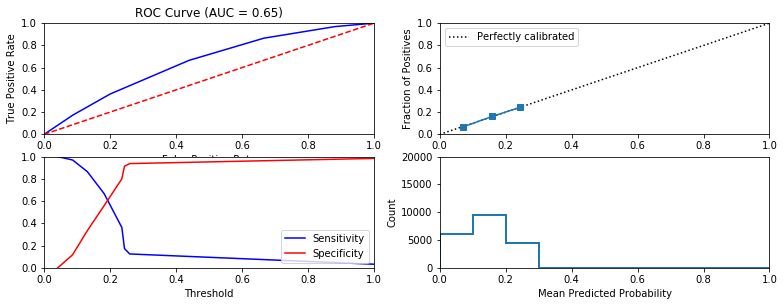


Similarity to LC grade ranking:  0.8863989075158132
Brier score: 0.12373502386731795
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.8499]


In [17]:
data_dict = prepare_data(feature_subset=['grade'])
grade_only_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')

grade_only_logistic = fit_classification(grade_only_logistic,data_dict,
                                         model_name = 'Grade only logistic l2')


### Interest rate

  Model: Interest rate only logistics l2
Fit time: 0.11 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.84895
              precision    recall  f1-score   support

  No default     0.8489    1.0000    0.9183     16979
     Default     0.0000    0.0000    0.0000      3021

    accuracy                         0.8489     20000
   macro avg     0.4245    0.5000    0.4592     20000
weighted avg     0.7207    0.8489    0.7796     20000



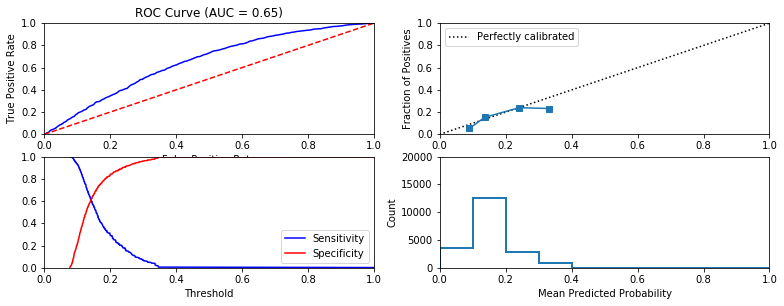


Similarity to LC grade ranking:  0.7919594781733205
Brier score: 0.1248645919851115
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.8499]


In [18]:
data_dict = prepare_data(feature_subset=['borrower_rate'])
interest_only_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')

interest_only_logistic = fit_classification(interest_only_logistic, data_dict, 
                                   model_name = 'Interest rate only logistics l2')

## Test models without grade or interest rate

In [19]:
final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "borrower_rate"]]
#final_features = [i for i in discrete_features + continuous_features]
#final_features = pd.DataFrame(data[final_features])
#final_features
data_dict = prepare_data(feature_subset = final_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Ridge Classifier

In [20]:
ridge_classifier = RidgeClassifier()
cv_parameters = {"alpha":np.logspace(-4, 4, num = 10)}

ridge_classifier = fit_classification(ridge_classifier, data_dict, 
                             cv_parameters = cv_parameters, model_name = "Ridge Classifier")

  Model: Ridge Classifier
Fit time: 0.64 seconds
Optimal parameters:
{'alpha': 166.81005372000558}

Accuracy:  0.84895
              precision    recall  f1-score   support

  No default     0.8489    1.0000    0.9183     16979
     Default     0.0000    0.0000    0.0000      3021

    accuracy                         0.8489     20000
   macro avg     0.4245    0.5000    0.4592     20000
weighted avg     0.7207    0.8489    0.7796     20000


Similarity to LC grade ranking:  0.1926358825472961


### Naive Bayes

  Model: Gaussian Naive Bayes
Fit time: 0.06 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.84895
              precision    recall  f1-score   support

  No default     0.8489    1.0000    0.9183     16979
     Default     0.0000    0.0000    0.0000      3021

    accuracy                         0.8489     20000
   macro avg     0.4245    0.5000    0.4592     20000
weighted avg     0.7207    0.8489    0.7796     20000



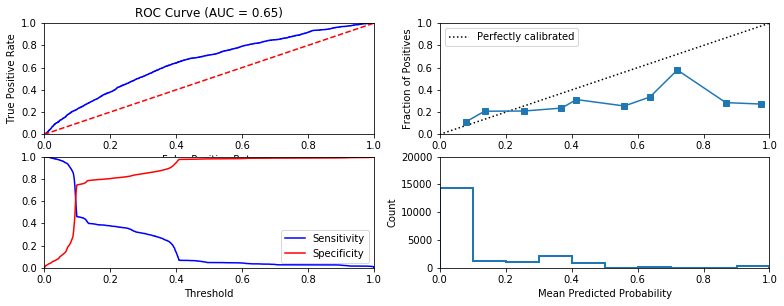


Similarity to LC grade ranking:  0.17502946948272416
Brier score: 0.13498558967104715
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.8421]


In [21]:
gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict,
                model_name = "Gaussian Naive Bayes")


### $l_1$ penalized logistic regression

In [22]:
# l1_logistic = LogisticRegression(penalty = 'l1')
# cv_parameters = {"C":np.logspace(0, 6, num = 10)}

# l1_logistic = fit_classification(l1_logistic, data_dict,
#                         cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression")

### $l_2$ penalized logistic regression

  Model: l2 Penalized Logistic Regression
Fit time: 1.51 seconds
Optimal parameters:
{'C': 0.0001}

Accuracy-maximizing threshold was: 0.1590103006760455
Accuracy:  0.8491
              precision    recall  f1-score   support

  No default     0.8493    0.9996    0.9184     16979
     Default     0.6000    0.0030    0.0059      3021

    accuracy                         0.8491     20000
   macro avg     0.7246    0.5013    0.4621     20000
weighted avg     0.8116    0.8491    0.7805     20000



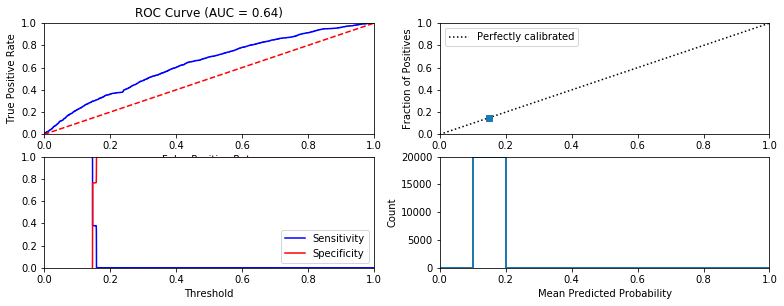


Similarity to LC grade ranking:  0.21978648492929584
Brier score: 0.12782571325642217
Were parameters on edge? : True
Score variations around CV search grid : 0.3686708240185236
[0.8499     0.8499     0.8499     0.8499     0.849      0.84743333
 0.84696667 0.84676667 0.84676667 0.84676667]


In [23]:
l2_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(-4, 4, num = 10)}

l2_logistic = fit_classification(l2_logistic, data_dict,
                        cv_parameters = cv_parameters, model_name = "l2 Penalized Logistic Regression")

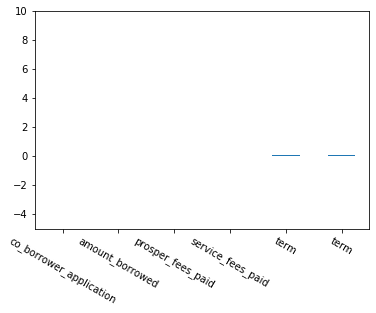

In [24]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision tree
Fit time: 0.89 seconds
Optimal parameters:
{'min_samples_leaf': 500}

Accuracy-maximizing threshold was: 1
Accuracy:  0.84895
              precision    recall  f1-score   support

  No default     0.8489    1.0000    0.9183     16979
     Default     0.0000    0.0000    0.0000      3021

    accuracy                         0.8489     20000
   macro avg     0.4245    0.5000    0.4592     20000
weighted avg     0.7207    0.8489    0.7796     20000



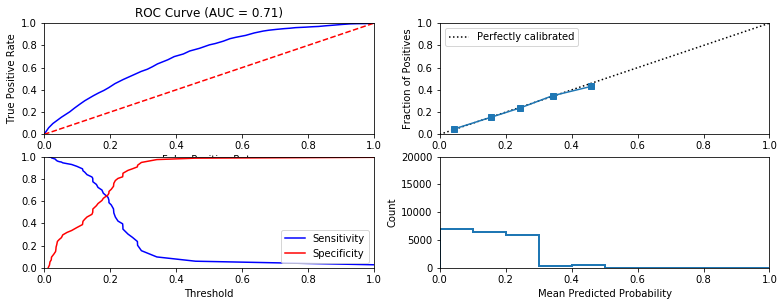


Similarity to LC grade ranking:  0.16188419085472244
Brier score: 0.1192939107245286
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.8499 0.8499 0.8499 0.8499 0.8499 0.8499 0.8499 0.8499 0.8499]


In [25]:
decision_tree = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

decision_tree = fit_classification(decision_tree, data_dict, 
                          cv_parameters = cv_parameters, model_name = "Decision tree")

In [26]:
# Visualize the decision tree
# Zooming-in is allowed by double click

# dot_data = StringIO()
# export_graphviz(decision_tree['model'], out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### Random forest

  Model: Random forest
Fit time: 315.35 seconds
Optimal parameters:
{'min_samples_leaf': 20, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.3857648186064266
Accuracy:  0.84975
              precision    recall  f1-score   support

  No default     0.8629    0.9785    0.9171     16979
     Default     0.5107    0.1261    0.2023      3021

    accuracy                         0.8498     20000
   macro avg     0.6868    0.5523    0.5597     20000
weighted avg     0.8097    0.8498    0.8091     20000



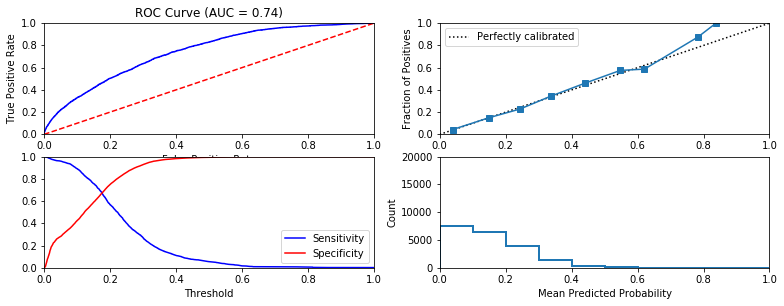


Similarity to LC grade ranking:  0.15449947428141564
Brier score: 0.11452158176917314
Were parameters on edge? : False
Score variations around CV search grid : 6.463729556303314
[0.79743333 0.79893333 0.79796667 0.79686667 0.7978     0.8325
 0.835      0.8341     0.83386667 0.8344     0.84353333 0.84403333
 0.84393333 0.84333333 0.8441     0.84846667 0.8489     0.8491
 0.8494     0.8494     0.8507     0.85083333 0.85063333 0.85106667
 0.85076667 0.8515     0.85176667 0.85146667 0.8513     0.85146667
 0.85133333 0.85186667 0.851      0.8518     0.8519     0.85156667
 0.8518     0.85186667 0.85193333 0.85153333 0.8504     0.85106667
 0.85076667 0.8508     0.85066667]


In [27]:
random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 'n_estimators': [35, 60, 80, 100, 150] }

random_forest = fit_classification(random_forest, data_dict,
                                   cv_parameters=cv_parameters, model_name="Random forest")

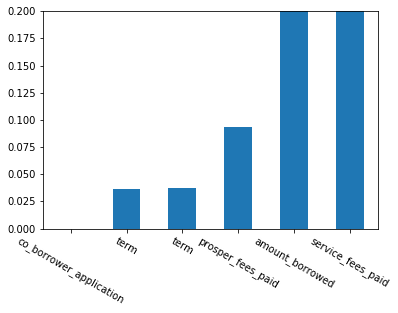

In [28]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

In [29]:
# ## A decision tree trained on the scores of random forest
# trepin_tree = DecisionTreeClassifier(min_samples_leaf = 100, max_depth = 4)
# trepin_tree.fit(random_forest['y_pred_probs'].reshape(-1,1),data_dict['y_test'])
# dot_data = StringIO()
# export_graphviz(trepin_tree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### Bagged trees

  Model: Bagged trees
Fit time: 672.27 seconds
Optimal parameters:
{'min_samples_leaf': 50, 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.4741333189559673
Accuracy:  0.85195
              precision    recall  f1-score   support

  No default     0.8573    0.9905    0.9191     16979
     Default     0.5785    0.0732    0.1299      3021

    accuracy                         0.8519     20000
   macro avg     0.7179    0.5318    0.5245     20000
weighted avg     0.8152    0.8519    0.7999     20000



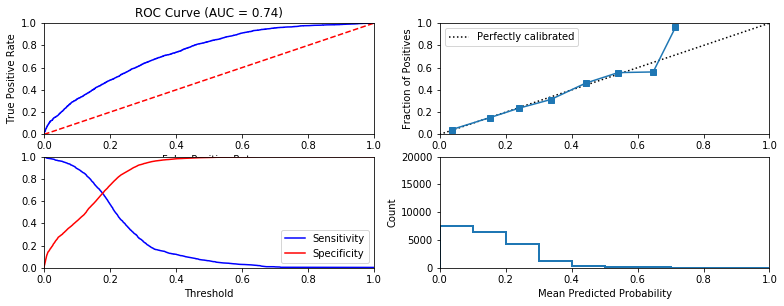


Similarity to LC grade ranking:  0.14681397985135544
Brier score: 0.11521947939687466
Were parameters on edge? : False
Score variations around CV search grid : 0.9870353687673765
[0.84336667 0.84263333 0.8439     0.84353333 0.84363333 0.84843333
 0.84823333 0.8478     0.84843333 0.84856667 0.8505     0.8506
 0.85033333 0.8505     0.8504     0.8507     0.85096667 0.85076667
 0.85103333 0.8509     0.8501     0.85036667 0.85       0.85006667
 0.85023333 0.84953333 0.84956667 0.84946667 0.84946667 0.84956667
 0.8498     0.8499     0.8499     0.8498     0.84983333]


In [30]:
bagged_trees = RandomForestClassifier(max_features = 1.0)
cv_parameters = {'min_samples_leaf':[5, 10, 25, 50, 75, 100, 200], 'n_estimators': [60, 100, 150, 200, 300] }

bagged_trees = fit_classification(bagged_trees, data_dict,
                                   cv_parameters=cv_parameters, model_name="Bagged trees")

### Multi-layer perceptron

  Model: Multi-Layer Perceptron
Fit time: 411.03 seconds
Optimal parameters:
{'hidden_layer_sizes': 100}

Accuracy-maximizing threshold was: 0.4861110408709919
Accuracy:  0.85075
              precision    recall  f1-score   support

  No default     0.8566    0.9900    0.9184     16979
     Default     0.5479    0.0682    0.1213      3021

    accuracy                         0.8508     20000
   macro avg     0.7022    0.5291    0.5199     20000
weighted avg     0.8099    0.8508    0.7980     20000



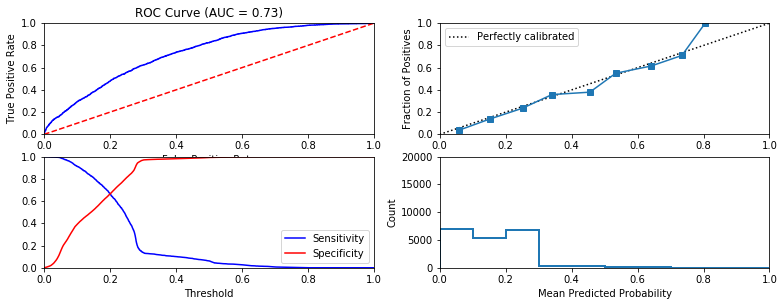


Similarity to LC grade ranking:  0.1481178386306645
Brier score: 0.11662118241920238
Were parameters on edge? : False
Score variations around CV search grid : 0.13317143864320338
[0.8499     0.8501     0.85046667 0.85103333 0.85046667 0.85076667]


In [31]:
mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes':[(1), (10), (50), (100), (5, 5), (10, 10)]}

mlp = fit_classification(mlp, data_dict,
                         cv_parameters = cv_parameters, model_name="Multi-Layer Perceptron")

### Light GBM

  Model: Light GBM
Fit time: 23.29 seconds
Optimal parameters:
{'n_estimators': 60, 'num_leaves': 20}

Accuracy-maximizing threshold was: 0.4881470597056431
Accuracy:  0.85185
              precision    recall  f1-score   support

  No default     0.8566    0.9914    0.9191     16979
     Default     0.5829    0.0675    0.1210      3021

    accuracy                         0.8518     20000
   macro avg     0.7197    0.5295    0.5201     20000
weighted avg     0.8153    0.8518    0.7986     20000



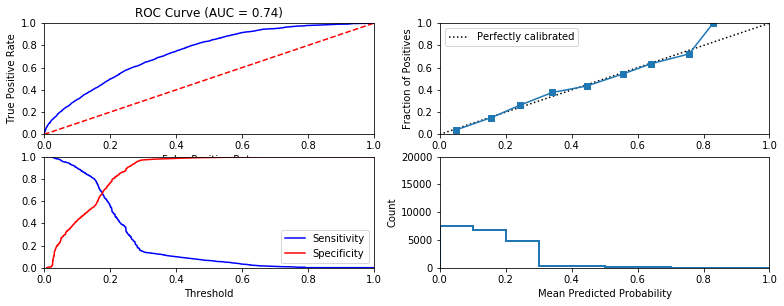


Similarity to LC grade ranking:  0.1536271700878448
Brier score: 0.11501730375121172
Were parameters on edge? : False
Score variations around CV search grid : nan
[       nan 0.8511     0.85206667 0.85186667 0.8516            nan
 0.85183333 0.8522     0.85133333 0.8517            nan 0.85173333
 0.8519     0.85123333 0.85156667        nan 0.85206667 0.85156667
 0.85206667 0.8517            nan 0.85206667 0.8518     0.85086667
 0.8509    ]


In [32]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

LightGBM = LGBMClassifier()
cv_parameters = {'num_leaves':[1, 10, 20, 30, 40], 'n_estimators': [35, 60, 80, 100, 150] }

LightGBM = fit_classification(LightGBM, data_dict,
                                   cv_parameters=cv_parameters, model_name="Light GBM")

## Test regression models
### Lasso-Lars regressor

In [33]:
# First, trying LASSO penalized regression with a variety of parameters,
# it becomes clear a simple regression is best

cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_lasso = fit_regression(linear_model.LassoLars(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Lasso")

  Model: Lasso  Return column: ret_PESS
Fit time: 0.28 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: 0.15777175569802915
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 108.73503712186032
All test scores : [ 0.12391231  0.12391231  0.1246795   0.12906773  0.00250605 -0.01127411
 -0.01127411 -0.01127411]
  Model: Lasso  Return column: ret_OPT
Fit time: 0.32 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: 0.021470588584063588
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -2.632487185023721
All test scores : [-0.08014381 -0.08014381 -0.07980375 -0.07859004 -0.08065891 -0.08065891
 -0.08065891 -0.08065891]
  Model: Lasso  Return column: ret_INTa
Fit time: 0.3 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: 0.17361224970705003
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 111.33402798354275
All test scores : [ 0.1153

### Ridge regressor

In [34]:
cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_ridge = fit_regression(linear_model.Ridge(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Ridge")

  Model: Ridge  Return column: ret_PESS
Fit time: 0.29 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.17612661976804678
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 0.05325241533362927
All test scores : [0.12492967 0.12492967 0.12492967 0.12492967 0.12492974 0.12493034
 0.12493635 0.12499623]
  Model: Ridge  Return column: ret_OPT
Fit time: 0.24 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.02478052210025561
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.031369333862783094
All test scores : [-0.08014381 -0.08014381 -0.08014381 -0.08014381 -0.08014379 -0.08014356
 -0.08014129 -0.08011868]
  Model: Ridge  Return column: ret_INTa
Fit time: 0.27 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.1856910463889362
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 0.07750198154986125
All test scores : [0.1153231  0.1153231

### Ordinary least squares

In [35]:
reg_linear = fit_regression(linear_model.LinearRegression(), data_dict,
               separate = False, model_name = "Linear Regression")

  Model: Linear Regression  Return column: ret_PESS
Fit time: 0.06 seconds
Optimal parameters:
{}

Testing r2 score: 0.17613361794005966
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 0.0
All test scores : [0.12504423]
  Model: Linear Regression  Return column: ret_OPT
Fit time: 0.05 seconds
Optimal parameters:
{}

Testing r2 score: 0.024802562043752197
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-0.08008129]
  Model: Linear Regression  Return column: ret_INTa
Fit time: 0.06 seconds
Optimal parameters:
{}

Testing r2 score: 0.1856946108607851
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 0.0
All test scores : [0.11543783]
  Model: Linear Regression  Return column: ret_INTb
Fit time: 0.05 seconds
Optimal parameters:
{}

Testing r2 score: 0.1530518011812041
Were parameters on edge (model) : False
Score variations around CV search grid (

### Multi-layer perceptron regressor

In [36]:
cv_parameters = { 'alpha':[0.001, 0.01, 0.1, 1, 10, 100],
                  'hidden_layer_sizes':[(1), (10), (50), (100), (200), (5, 5), (10, 10)] }

reg_mlp = fit_regression(MLPRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Multi-Layer Perceptron")

  Model: Multi-Layer Perceptron  Return column: ret_PESS
Fit time: 334.59 seconds
Optimal parameters:
{'alpha': 0.001, 'hidden_layer_sizes': 200}

Testing r2 score: 0.2390840438207419
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 110.26381391022588
All test scores : [-2.92860800e-03  9.65928397e-02  1.77056197e-01  1.98610613e-01
  2.17835393e-01  3.05718326e-02  1.60968950e-01  8.34271175e-03
  7.06226741e-02  1.57758075e-01  2.05444729e-01  1.51339048e-01
  1.06082805e-01  1.45484558e-01 -9.59442317e-03  1.14018881e-01
  1.13556270e-01  1.41529363e-01  1.23240542e-01  1.08668746e-01
  1.45887762e-01 -2.79680597e-03  6.94653973e-03  6.49150809e-05
 -1.39407392e-02 -1.87019282e-02 -1.03177765e-02 -9.75417577e-03
 -8.75084890e-03 -8.66949723e-03 -2.23582194e-02 -1.95075497e-02
 -7.75610984e-03 -1.03389972e-02 -1.27329441e-02 -1.04782245e-02
 -1.44920519e-02 -1.06012913e-02 -1.41621678e-02 -8.88395741e-03
 -9.92451748e-03 -1.13618151e-02]
  Model

### Random forest regressor

In [37]:
cv_parameters = {'min_samples_leaf':[75, 100, 200, 300, 400],
                 'n_estimators': [35, 45, 55, 65, 80, 90, 100] }

reg_rf = fit_regression(RandomForestRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Random forest regressor")

  Model: Random forest regressor  Return column: ret_PESS
Fit time: 196.05 seconds
Optimal parameters:
{'min_samples_leaf': 75, 'n_estimators': 90}

Testing r2 score: 0.3132111667758547
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 12.223286843451328
All test scores : [0.22742234 0.22875706 0.22772106 0.22843033 0.22833516 0.22947257
 0.22870358 0.22232914 0.22225981 0.22376882 0.22321379 0.2233802
 0.22363295 0.22334089 0.21209937 0.2120619  0.21275021 0.21317527
 0.21277307 0.21301128 0.21416096 0.20605004 0.20529838 0.20628124
 0.20663087 0.20672425 0.20589552 0.2069726  0.20182448 0.20336222
 0.20295764 0.20286169 0.20142348 0.20195736 0.2023139 ]
  Model: Random forest regressor  Return column: ret_OPT
Fit time: 207.9 seconds
Optimal parameters:
{'min_samples_leaf': 75, 'n_estimators': 100}

Testing r2 score: 0.06585042004441466
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -24.242367367499856
All 

## Learning curve of classifiers
Start with 25 training points and double the training size every time
(This cell will take at least 30 mins to run)

In [53]:
test_sizes = np.array([25 * 2**k for k in range(10)])
num_rows = len(test_sizes)
T = 10
df_learning_logistic = pd.DataFrame(data=np.zeros((num_rows,T)),columns=list(range(T)))
df_learning_rf = pd.DataFrame(data=np.zeros((num_rows,T)),columns=list(range(T)))

df_learning_logistic.index = test_sizes
df_learning_rf.index = test_sizes

for t in range(T):
    
    # just to get test data; training size is irrelavent here
    data_dict_t = prepare_data(n_samples_train=10000,n_samples_test=10000,
                                   feature_subset=final_features, random_state=t)
    X_test_t = data_dict_t['X_test']
    y_test_t = data_dict_t['y_test']
    
    for size in test_sizes:
        
        # get training data based on the specified size
        data_dict_t = prepare_data(n_samples_train=int(size),n_samples_test=10000,
                                   feature_subset=final_features, random_state=t)
        
        l2_logistic_t = LogisticRegression(penalty = 'l2')
        cv_parameters = {"C":np.logspace(-4, 4, num = 10)}

        l2_logistic_t = fit_classification(l2_logistic_t, data_dict_t,
                            cv_parameters = cv_parameters, model_name = "l2 Penalized Logistic Regression",
                                      print_to_screen = False, output_to_file = False)

        random_forest_t = RandomForestClassifier()
        cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20], 'n_estimators': [35, 60, 80, 100] }

        random_forest_t = fit_classification(random_forest_t, data_dict_t,
                                       cv_parameters=cv_parameters, model_name="Random forest",
                                             print_to_screen = False, output_to_file = False)

        df_learning_logistic.loc[size,t] = roc_auc_score(y_test_t, l2_logistic_t['model'].predict_proba(X_test_t)[:,1])
        df_learning_rf.loc[size,t] = roc_auc_score(y_test_t, random_forest_t['model'].predict_proba(X_test_t)[:,1])


df_learning = pd.DataFrame(data=np.zeros((num_rows,2)),columns=['l2 logistic', 'random forest'])
df_learning.index = test_sizes
df_learning.loc[:,'l2 logistic'] = np.mean(df_learning_logistic.iloc[:,:11],axis=1)
df_learning.loc[:,'random forest'] = np.mean(df_learning_rf.iloc[:,:11], axis=1)
df_learning.plot()
plt.ylabel('Testing AUC')
plt.xlabel('Training Size')
plt.show()

KeyboardInterrupt: 

## Time stability test

In [54]:
data.loan_status.value_counts()

0.0    624679
1.0    110504
Name: loan_status, dtype: int64

### On the whole time period

  Model: Random forest
Fit time: 20.14 seconds
Optimal parameters:
{'min_samples_leaf': 40, 'n_estimators': 5}

Accuracy-maximizing threshold was: 0.38883497149343443
Accuracy:  0.8477142857142858
              precision    recall  f1-score   support

  No default     0.8509    0.9946    0.9171      5931
     Default     0.5224    0.0327    0.0616      1069

    accuracy                         0.8477      7000
   macro avg     0.6866    0.5137    0.4894      7000
weighted avg     0.8007    0.8477    0.7865      7000



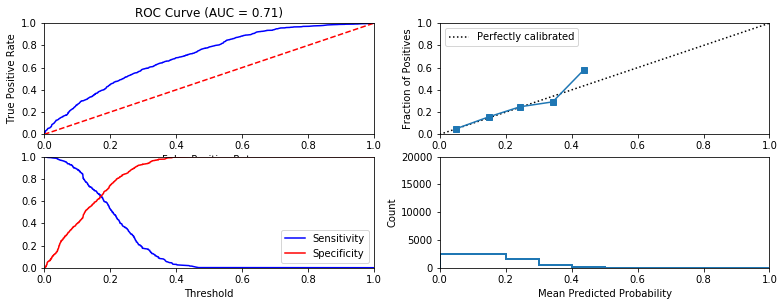


Similarity to LC grade ranking:  0.16459869461633106
Brier score: 0.12042820781137027


{'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=40, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=5,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.00916084, 0.10240727, 0.11321924, ..., 0.19015348, 0.20383766,
        0.20383766])}

In [55]:
data_dict_test = prepare_data(n_samples_train = 9000, n_samples_test = 7000, feature_subset = final_features)
cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 'n_estimators': [5, 10, 15, 20, 25] }

fit_classification(RandomForestClassifier(), data_dict_test,
                   cv_parameters = cv_parameters, model_name = "Random forest", output_to_file = False)

### Train and test on the first 2 years

In [56]:
#np.sum(data.issue_d < datetime.date(2015,6,1))
np.sum(data.issue_d < np.datetime64('2014-12-31'))

149699

  Model: Random forest
Fit time: 20.89 seconds
Optimal parameters:
{'min_samples_leaf': 13, 'n_estimators': 20}

Accuracy-maximizing threshold was: 0.3966215604713658
Accuracy:  0.831
              precision    recall  f1-score   support

  No default     0.8508    0.9671    0.9052      5843
     Default     0.4637    0.1435    0.2191      1157

    accuracy                         0.8310      7000
   macro avg     0.6572    0.5553    0.5622      7000
weighted avg     0.7868    0.8310    0.7918      7000



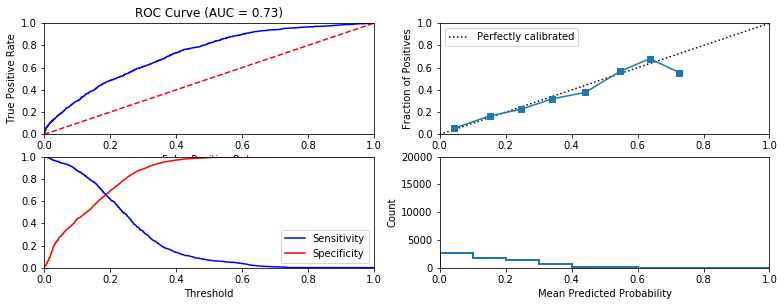


Similarity to LC grade ranking:  0.15796531860145965
Brier score: 0.1247262811630372


{'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=13, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=20,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.17903738, 0.10038034, 0.01744186, ..., 0.13552458, 0.12735702,
        0.156478  ])}

In [57]:
start_date = np.datetime64('2013-01-01')
end_date = np.datetime64('2014-12-31')

data_dict_test = prepare_data(date_range_train = (start_date, end_date), date_range_test = (start_date, end_date),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = final_features)

cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 'n_estimators': [5, 10, 15, 20, 25] }

fit_classification(RandomForestClassifier(), data_dict_test,
                   cv_parameters = cv_parameters, model_name = "Random forest", output_to_file = False)

### Train on the first 2 years and test on the last year

  Model: Random forest
Fit time: 19.56 seconds
Optimal parameters:
{'min_samples_leaf': 13, 'n_estimators': 20}

Accuracy-maximizing threshold was: 0.3966215604713658
Accuracy:  0.9118571428571428
              precision    recall  f1-score   support

  No default     0.9616    0.9460    0.9538      6728
     Default     0.0472    0.0662    0.0551       272

    accuracy                         0.9119      7000
   macro avg     0.5044    0.5061    0.5045      7000
weighted avg     0.9261    0.9119    0.9189      7000



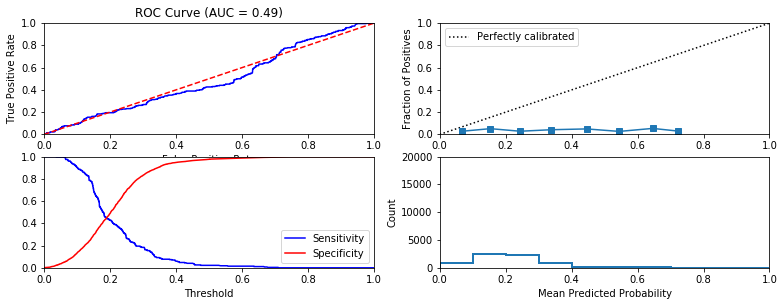


Similarity to LC grade ranking:  0.15796531860145965
Brier score: 0.08039909534844232


{'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=13, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=20,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.2599607 , 0.21394454, 0.3249159 , ..., 0.31381318, 0.21377097,
        0.20218554])}

In [58]:
start_date_train = np.datetime64('2013-01-01')
end_date_train = np.datetime64('2014-12-31')
start_date_test = np.datetime64('2018-01-01')
end_date_test = np.datetime64('2018-12-31')

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = final_features)

cv_parameters = {'min_samples_leaf':[1, 2, 3, 5, 8, 13, 17, 20, 40], 'n_estimators': [5, 10, 15, 20, 25] }

fit_classification(RandomForestClassifier(), data_dict_test,
                   cv_parameters = cv_parameters, model_name = "Random forest", output_to_file = False)

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [59]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_random = test_investments(data_dict,strategy = test_strategy, 
                            num_loans = 1000, output_to_file = False, random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_random[ret_col]['average return']))

strategy: Random
ret_PESS: 0.014940905795160879
ret_OPT: 0.056582323727499884
ret_INTa: 0.024681210196163803
ret_INTb: 0.03429977886861588


In [60]:
test_strategy = 'Ranking'

print('strategy:',test_strategy)
strat_rank = test_investments(data_dict, classifier=random_forest, strategy = test_strategy, 
                        num_loans = 1000, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy: Ranking
ret_PESS: 0.07329501586281616
ret_OPT: 0.0750225748173435
ret_INTa: 0.02651452387456757
ret_INTb: 0.03233399879156022


In [61]:
test_strategy = 'Regression'

print('strategy:',test_strategy)
strat_reg = test_investments(data_dict, regressor=reg_rf, strategy = test_strategy, 
                        num_loans = 1000)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_reg[ret_col]['average return']))

strategy: Regression
ret_PESS: 0.11261458350107531
ret_OPT: 0.07252333437043564
ret_INTa: 0.026227890413804668
ret_INTb: 0.03475332572764434


In [62]:
test_strategy = 'Two-stage'

## For the two-stage strategy we need to fit a new RF regressor with separate = True
cv_parameters = {'min_samples_leaf':[25, 50, 75, 100, 200, 300, 400],
                 'n_estimators': [35, 45, 55, 65, 80, 90, 100] }

reg_rf_separate = fit_regression(RandomForestRegressor(), data_dict,
                       cv_parameters = cv_parameters, separate = True, model_name = "Random forest regressor", 
                       print_to_screen = False, output_to_file = False)

print('strategy:',test_strategy)
two_stage = test_investments(data_dict, classifier = random_forest, regressor = reg_rf_separate, 
                             strategy = test_strategy, num_loans = 1000)

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

strategy: Two-stage
ret_PESS: 0.1121903245210521
ret_OPT: 0.06575101629266852
ret_INTa: 0.026958068553870954
ret_INTb: 0.03297131804048246


## Sensitivity test of portfolio size

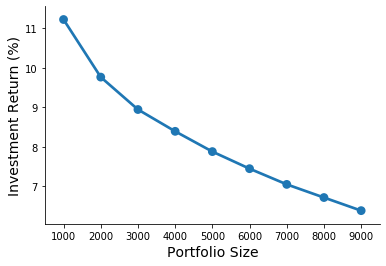

In [63]:
result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, regressor = reg_rf_separate, classifier = random_forest, 
                            strategy = 'Two-stage', num_loans = num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()

## Optimization: an example
In this section, we implement three different optimization models. To illustrate and compare these models we will only use the M1-PESS definition and the predicted returns from the previously tested two-stage strategy.

### Directly maximize total profit

In [64]:
# In this section we implement two versions of optimization problem
# The first one is simply maximizing the total expected profit
ret_col = 'ret_PESS'
test_pool = two_stage[ret_col]['test data']
num_loans = 1000

# create the model
m = Model('model_maximizing_profit')
Var = {}

# add the binary variable to the model
for i in range(test_pool.shape[0]):
        Var[i] = m.addVar(vtype=GRB.BINARY)

# add the number of loans constraint
m.addConstr(num_loans == quicksum(Var[i] for i in range(test_pool.shape[0])))

# set the objective to maximize total profit
m.setObjective(quicksum(Var[i]*test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.amount_borrowed.iloc[i]
                        for i in range(test_pool.shape[0])), GRB.MAXIMIZE)

m.setParam('OutputFlag',False)
m.optimize()

# save only the selected loans and compute the average return
test_pool['selection'] = np.array(m.X)
pf_0 = test_pool[test_pool.selection > 0]

print('return:',np.dot(pf_0[ret_col],pf_0.amount_borrowed)/np.sum(pf_0.amount_borrowed))

Using license file c:\gurobi\gurobi.lic
Academic license - for non-commercial use only
return: 0.06831754247123985


### Maximize profit with budget constraint

In [65]:
m = Model('model_maximizing_profit_constrained')
Var = {}
Budget = 10*1000000

for i in range(test_pool.shape[0]):
    Var[i] = m.addVar(vtype=GRB.BINARY)

# add the budget constraint
m.addConstr(Budget >= quicksum(Var[i] * test_pool.amount_borrowed.iloc[i]
                       for i in range(test_pool.shape[0])))

m.addConstr(num_loans >= quicksum(Var[i] for i in range(test_pool.shape[0])))

# add a minimum number of loans constraint
m.addConstr(900 <= quicksum(Var[i] for i in range(test_pool.shape[0])))

m.setObjective(quicksum(Var[i]*test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.amount_borrowed.iloc[i]
                        for i in range(test_pool.shape[0])), GRB.MAXIMIZE)

m.setParam('OutputFlag',False)
m.optimize()

test_pool['selection'] = np.array(m.X)
pf_0 = test_pool[test_pool.selection > 0]

print('return:',np.dot(pf_0[ret_col],pf_0.amount_borrowed)/np.sum(pf_0.amount_borrowed))

return: 0.10492285110371322


### Maximize profit with risk-return tradeoff

In [66]:
## First we need to train a clustering model to estimate the variance of return
n_clusters = 5

train_set = data_dict['train_set']
data_train = data.loc[train_set,:]

# Create a dataframe for testing, including the score
data_test = two_stage[ret_col]['test data']

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_dict['X_train'])
data_train['clusID'] = kmeans.predict(data_dict['X_train'])
data_test['clusID'] = kmeans.predict(data_dict['X_test'])
data_test['volatility'] = 0

for idx in range(n_clusters):
    std_clus = np.std(data_train[ret_col][data_train.clusID == idx])
    data_test.volatility[data_test.clusID == idx] = std_clus

## Specify the parameters of the optimization model
# beta: penalty factor on the risk
beta = 0.009
Budget = 10.7*1000000

m = Model('model_volatility_constrained')

for i in range(test_pool.shape[0]):
    Var[i] = m.addVar(vtype=GRB.BINARY)

# add the budget constraint
m.addConstr(Budget >= quicksum(Var[i] * test_pool.amount_borrowed.iloc[i]
                       for i in range(test_pool.shape[0])))

m.addConstr(num_loans >= quicksum(Var[i] for i in range(test_pool.shape[0])))
m.addConstr(900 <= quicksum(Var[i] for i in range(test_pool.shape[0])))

# the expected return is adjusted based on the risk
m.setObjective(quicksum(Var[i]*(test_pool['predicted_return_'+  ret_col].iloc[i] -
                                beta * test_pool.volatility.iloc[i])
                                *test_pool.amount_borrowed.iloc[i]
                                for i in range(test_pool.shape[0])), GRB.MAXIMIZE)

m.setParam('OutputFlag',False)
m.optimize()

test_pool['selection'] = np.array(m.X)
pf_0 = test_pool[test_pool.selection > 0]

print('return:',np.dot(pf_0[ret_col],pf_0.amount_borrowed)/np.sum(pf_0.amount_borrowed))

return: 0.10277304536597648
